# Experiments

In [2]:
import numpy as np
import ot
from numba import njit, jit
from scipy.stats import norm, skewnorm
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time 
from typing import Callable
import pickle

import warnings
# warnings.filterwarnings("ignore")

rng = np.random.default_rng()

In [3]:
from pathlib import Path

figure_folder = Path().resolve().parent / 'report_and_presentation' / 'figures'
results_folder = Path().resolve() / 'results'

In [4]:
# utility functions
normalize = lambda x, dim=-1: x /np.sum(x, axis=dim)

In [5]:
# 1D 
@njit
def is_in_power_cell(y, ind_i: int, ind_j : int,
                     phis : np.ndarray,
                     barycenter_point : np.ndarray):
    """
    y : (D)
    """
    assert -1 < ind_i < barycenter_point.shape[0]
    assert -1 < ind_j < phis.shape[0]

    c_values = ((y[np.newaxis, :]  - barycenter_point)**2).sum(-1) - phis[ind_j] # (M) 
    in_voronoi = c_values[ind_i] == c_values.min()
    return in_voronoi

@njit
def compute_value_a(ind_i: int, ind_j : int,
                    phis : np.ndarray,
                    Y : np.ndarray, 
                    barycenter_point : np.ndarray):
    """ using Monte Carlo method"""
    assert ind_i < phis.shape[1]
    assert ind_j < phis.shape[0]

    K = Y.shape[0]
    monte_carlo_sum = 0
    for k in range(K):
        monte_carlo_sum += 1.*is_in_power_cell(Y[k], ind_i, ind_j, phis, barycenter_point)
    return monte_carlo_sum / K

@njit
def compute_value_b(ind_i : int, ind_j : int,
                    phis, Y, barycenter_point : np.ndarray):
    """ using Monte Carlo method"""
    assert ind_i < phis.shape[1]
    assert ind_j < phis.shape[0]

    K = Y.shape[0]
    monte_carlo_sum = np.zeros(Y.shape[1])
    for k in range(K):
        monte_carlo_sum += Y[k]*is_in_power_cell(Y[k], ind_i, ind_j, phis, barycenter_point)
    return monte_carlo_sum / K  

@njit
def compute_gradient_phi_ij(ind_i: int, ind_j:int, phis, barycenter_point,
                        Y : np.ndarray):

    
    a_ij = compute_value_a(ind_i, ind_j, phis, Y, barycenter_point) # float
    
    N, M = phis.shape
    grad_f = (1/M - a_ij)/N

    return grad_f, a_ij

@njit
def compute_gradient_phi_j(ind_j : int, phis, barycenter_point,
                           Y : np.ndarray):
    """ 
    Returns :
    grad_phi_j : array (M)
    a_j : array (M)
    """
    M = phis.shape[1]
    grad_phi_j = np.zeros(M)
    a_j = np.zeros(M)
    for i in range(M):
        grad_phi_j[i], a_j[i] = compute_gradient_phi_ij(i, ind_j, phis,
                                                barycenter_point,
                                                Y)
    return grad_phi_j, a_j


In [6]:
def plot_ascent_convergence(J, ascent_criteria_list, config_name:str):
    fig = plt.figure()
    for j in range(J):
        plt.plot(ascent_criteria_list[j], label=f'$||\partial F / \partial \phi_{j} ||$')
    plt.title(f'Evolution of convergence criteria for ascent step')
    plt.legend()
    fig.savefig(figure_folder / f'ascent_criteria_{config_name}.png')

In [9]:
# Optimizing estimate of barycenter support 
@jit
def ascent_snap_algo(x, nIter: int, n_samples: int,
                     ascent_eps: float,
                     ascent_beta: float,
                     ascent_alpha: float,
                     J : int,
                     M : int,
                     sample_from_input_distribution : Callable,
                     D : int = 1,
                     max_while_loop: int=2000,
                     plot : bool = False,
                     config_exp : str ='default'):

    # initial potentials
    phis = np.zeros((J, M))
       
    samples_per_input = [sample_from_input_distribution(j, n_samples=n_samples) for j in range(J)]
    for i in range(nIter):
        time1 = time()
        # ascent step 
        ascent_criteria_list = []
        weight_a = np.zeros((J, M))
        for j in range(J):
            z_0 = np.zeros(M)
            # w_0 = phis[j]
            grad_phi_j, _ = compute_gradient_phi_j(j, phis, x,
                                                    samples_per_input[j])
            ascent_criteria = [np.linalg.norm(grad_phi_j, ord=1)]

            while ascent_criteria[-1] > ascent_eps:
                z_0 = ascent_beta*z_0 + grad_phi_j
                phis[j] = phis[j] + ascent_alpha*z_0
                # w_0 = w_0 + ascent_alpha*z_0
                # phis[j] = w_0
                grad_phi_j, a_j = compute_gradient_phi_j(j, phis, x,
                                                        samples_per_input[j])
                ascent_criteria += [np.linalg.norm(grad_phi_j, ord=1)]
                if len(ascent_criteria) > max_while_loop:
                    print('Warning : max_while_loop reached')
                    break
            
            ascent_criteria_list += [ascent_criteria]
            weight_a[j] = a_j
            print(f'criteria for j {j} : {ascent_criteria[-1]}')
        ascent_time = time() - time1
        # print('ascent step at iteration {i} done in {time:.2f} min'.format(i=i, time=(time_end - time1)/60))
        if plot :
            plot_ascent_convergence(J, ascent_criteria_list, f'msamples{n_samples}_iter{i}_{config_exp}')

        # snap step
        point_b = np.zeros((J, M, D)) # (J, M, D)
        time2 = time()
        for j in range(J):
            for i in range(M):
                point_b[j, i] = compute_value_b(i, j, phis, samples_per_input[j], x)
        # weight_a = weight_a[:, :, np.newaxis] # (J, M, 1) # TO COMMENT !! 
     
        for i in range(M):
            # x[i] = np.sum(weight_a[:, i] * point_b[:, i], axis=0)
            x[i] = np.sum(point_b[:, i], axis=0)
            x[i] /= np.maximum( np.sum(weight_a[:, i]), 1e-19 )
        # print('snap step at iteration {i} done in {time} s'.format(i=i, time=time()-time2))
        snap_time = time() - time2

    return x, phis, ascent_criteria_list, ascent_time, snap_time

C:\Users\INES\AppData\Local\Temp\ipykernel_13416\2439744480.py:3: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def ascent_snap_algo(x, nIter: int, n_samples: int,


## 1D Case : Gaussians 


In [3]:
means = [1., 5., 10.]
stds = [.5, .2, .8] # rng.random(3) + .05
t = np.linspace(-5, 15, 100)

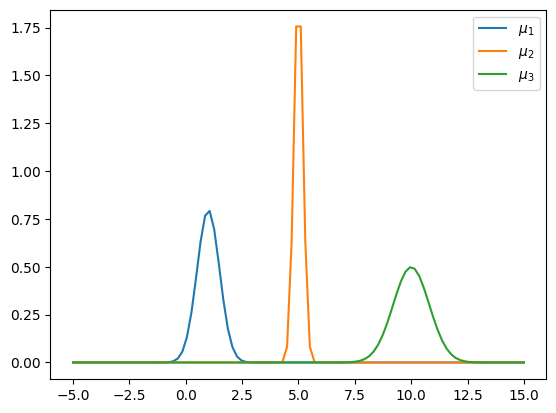

In [4]:
fig = plt.figure()

plt.plot(t, norm.pdf(t, loc=means[0], scale=stds[0]), label='$\mu_1$')
plt.plot(t, norm.pdf(t, loc=means[1], scale=stds[1]), label='$\mu_2$')
plt.plot(t, norm.pdf(t, loc=means[2], scale=stds[2]), label='$\mu_3$')

plt.legend()
plt.show()

### Method on a fixed grid 

In [5]:
# fixed grid 
M = 100
x = np.linspace(-5, 15, M)

#### **Method 1 :** Compute the barycenter on a refined grid using the cumulative function

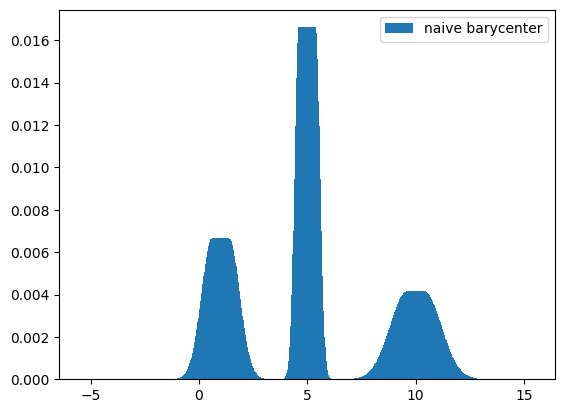

In [97]:
time_naive_0 = time.time()

coeffs = np.zeros(M)
for j in range(3):
    coeffs += norm.pdf(x, loc=means[j], scale=stds[j])
coeffs /= np.sum(coeffs)

time_naive_1 = time.time()

# plot barycenter 
plt.bar(x, coeffs, label='naive barycenter')
# plt.plot(t, norm.pdf(t, loc=means[0], scale=stds[0]), label='$\mu_1$')
# plt.plot(t, norm.pdf(t, loc=means[1], scale=stds[1]), label='$\mu_2$')
# plt.plot(t, norm.pdf(t, loc=means[2], scale=stds[2]), label='$\mu_3$')

plt.legend()

plt.show()

### **Method 2:** Using regularized bregman method

Here, the input measures have to be discretized on the same grid as the target barycenter.

In [6]:
A = np.zeros((M, 3))
vmin = .02
for j in range(3):
    a = norm.pdf(x, loc=means[j], scale=stds[j])
    A[:, j] = normalize( a + a.max()*vmin)

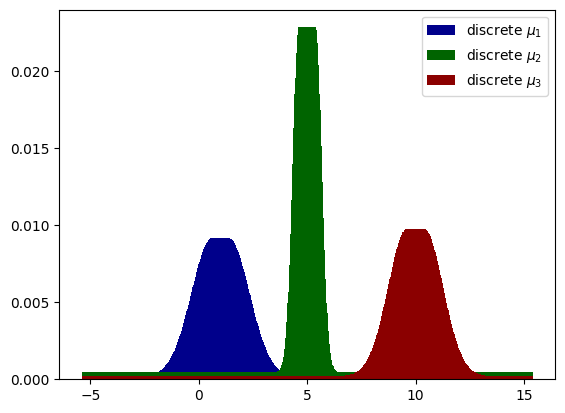

In [39]:
fig = plt.figure()

plt.bar(x, A[:, 0], label='discrete $\mu_1$', color = 'darkblue')
plt.bar(x, A[:, 1], label='discrete $\mu_2$', color = 'darkgreen')
plt.bar(x, A[:, 2], label='discrete $\mu_3$', color = 'darkred')
plt.legend()

plt.show()

In [41]:
# Bregman algo
# uniform weights
weights = np.ones(3) / 3

# Kernel 
epsilon = .05
[Y, X] = np.meshgrid(x, x)
K = np.exp(- (X - Y)**2/ epsilon )

# initialization 
v = np.ones((M, 3))
u = np.copy(v)

niter = 500
for i in tqdm(range(niter)):
    
    # update u
    for k in range(3): 
        u[:, k] = A[:, k] / np.dot(K, v[:, k])
    
    # compute barycenter
    b = np.zeros(M)
    for k in range(3):
        b += weights[k] * np.log( np.maximum(v[:, k] * np.dot(K, u[:, k]),
                                             1e-19*np.ones(M)))
    b = np.exp(b)

    # update v
    for k in range(3):
        v[:, k] = b / np.dot(K, u[:, k])
    

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 204.20it/s]


In [44]:
b = normalize(b)

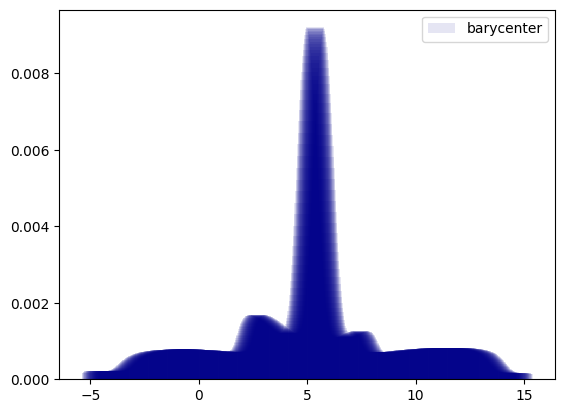

In [46]:
plt.bar(x, b, label='barycenter', color = 'darkblue')

plt.legend()
plt.show()

### **Method 3:** Stochastic wasserstein barycenter without refined grid

$\phi = {\phi_j^i}$

$C = d(x, y)^2 = ||x -y ||_2^2$ is the cost 

In [6]:
@jit
def sample_from_input_distribution(ind_j : int, n_samples : int = 10000):
    return norm.rvs(loc=means[ind_j], scale=stds[ind_j], size=(n_samples, 1))

In [8]:
x = np.linspace(0, 10, M)[:, np.newaxis] # (M, D)
x.shape

(100, 1)

In [ ]:
# [Y, X] = np.meshgrid(x, x)
# C = (X - Y)**2

In [ ]:
# 2D : plot Voronoi diagram 
# t = None
# [Y, X] = np.meshgrid(t, t)
# C = (X - Y)**2

In [105]:
# g, a = compute_gradient_phi_j(0, np.zeros((3, M)), x, n_samples=50)
# sam = sample_from_input_distribution(0, 10)
# b = compute_value_b(0, 0, np.zeros((3, M)), sam, x)

In [19]:
n_samples = 16000
nIter = 1
J = 3
D = 1
ascent_eps = 1e-4 # 1e-6
ascent_beta = .99
ascent_alpha = 1e-3

max_while_loop = 1000

In [38]:
ascent_criteria_list[0][-1]

0.5322916666666665

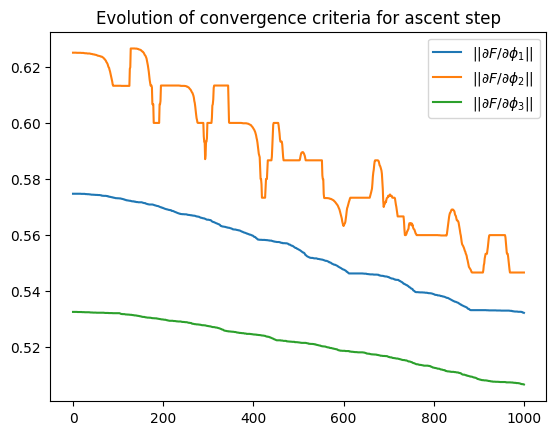

In [49]:
fig = plt.figure()
plt.plot(ascent_criteria_list[0], label='$||\partial F / \partial \phi_1 ||$')
plt.plot(ascent_criteria_list[1], label='$||\partial F / \partial \phi_2 ||$')
plt.plot(ascent_criteria_list[2], label='$||\partial F / \partial \phi_3 ||$')
plt.title(f'Evolution of convergence criteria for ascent step')
plt.legend()
fig.savefig(figure_folder / f'ascent_criteria_nsamples{n_samples}.png')

In [93]:
time_algo_0 = time.time()

new_x, new_phis, ascent_crit_list, a_j, point_b = ascent_snap_algo(x, nIter, n_samples)

time_algo_1 = time.time()

grad [-0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33 -0.33
 -0.33 -0.33 -0.33 -0.33]
phi_j [-0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033
 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033
 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033
 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033
 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033 -0.00033
 -0.00033 -0.0

KeyboardInterrupt: 

In [77]:
a_j.shape

(100,)

In [80]:
np.unique(new_phis)

array([-1.21641526])

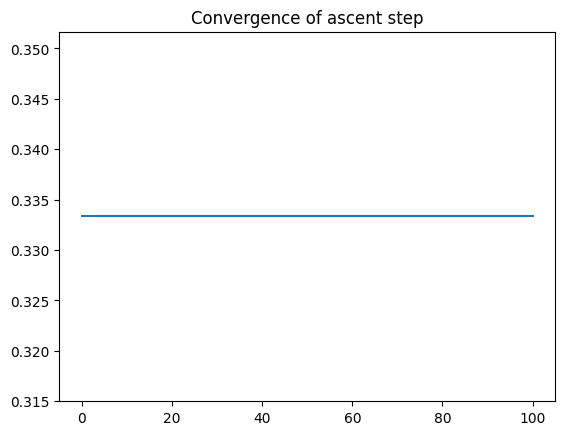

In [72]:
fig = plt.figure()

plt.plot(ascent_crit_list[0])
plt.title('Convergence of ascent step')

plt.show()

In [6]:
# with OT 
import ot 

weights = np.ones(3) / 3

# wasserstein
reg = 1e-3
ot.tic()
bary_wass = ot.bregman.barycenter(A, M, reg, weights)
ot.toc()


# ot.tic()
# bary_wass2 = ot.lp.barycenter(A, M, weights)
# ot.toc()

print('Wass Barycenter with OT : ', bary_wass.shape)

plt.plot(x, bary_wass, label='POT Wass')

plt.legend()
plt.show()

ModuleNotFoundError: No module named 'ot'

# 1D Skew norm
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html#scipy.stats.skewnorm
compare to the computation using  inverse cumulative function in 1D 

In [92]:
result_path_1D_skewnorm = results_folder / 'time_metrics_1D_skewnorm.pkl'
if not result_path_1D_skewnorm.exists():
    time_metrics_1D_skewnorm = {'Optimal_Monge_Map' : [],
                    'Iterative_Bregman' : [],
                    'Ascent_Snap_algorithm': {'total': [], 'ascent_time': [], 'snap_time': []}
                    }
else :
    with open(result_path_1D_skewnorm, 'rb') as f:
        time_metrics_1D_skewnorm = pickle.load(f)

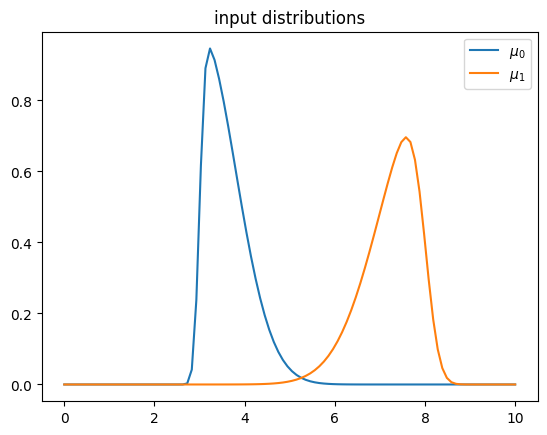

In [82]:
skews = [8, -4]
means = [3, 8]
stds = [.8, 1]

t = np.linspace(0, 10, 100)
fig = plt.figure()
for i in range(2):
    plt.plot(t, skewnorm.pdf(t, skews[i], loc=means[i], scale=stds[i]), label=f"$\mu_{i}$" )
plt.legend()
plt.title('input distributions')
plt.show()

### **Method 1** : Optimal Monge problem and inverse cumulative function

For two distributions $\mu_1$ and $\mu_2$, optimal Monge map writes $T=\mathcal{C}^{-1}_{\mu_2} o \mathcal{C}_{\mu_1}$

In class, we explain that the McCann's interpolation is, then, $$ \alpha_t = (tT + (1-t)Id)_\#\mu_1 $$ for $t\in [0, 1]$

In [83]:
def projection_map(X: np.ndarray, t: float):
    """ perform transformation of r. a. X """
    c_alpha = skewnorm.cdf(X, skews[0], means[0], stds[0]) 
    inv_c_beta = skewnorm.ppf(c_alpha, skews[1], means[1], stds[1])

    return t*inv_c_beta + (1-t)*X

In [85]:
sample_size = 2000
x = np.linspace(0, 10, 100)

In [ ]:
# plot geodesic path
fig = plt.figure(figsize=(10, 15))
ts = [0., .2, .5, .8, 1.]
for i, t in enumerate(ts):
  plt.subplot(5, 1, i+1)

  X = skewnorm.rvs(skews[0], means[0], stds[0], size=sample_size)
  Y = projection_map(X, t)
  plt.hist(Y, bins=50, density=True, label=f'$\\alpha_{{t}}$', alpha=.4)
  for k in range(2):
    plt.plot(x, skewnorm.pdf(x, skews[k], means[k], stds[k]), label=f'$\\mu_{k}$')

  plt.legend()

plt.suptitle("McCann's interpolant for different t")
fig.tight_layout()

fig.savefig('mccann_1D_2skew.png')

In [87]:
t = .5
time_method_1 = []
for _ in range(10):
    time_start = time()
    X = skewnorm.rvs(skews[0], means[0], stds[0], size=sample_size)
    Y = projection_map(X, t)
    b, _ = np.histogram(Y, bins=sample_size, density=True)
    time_method_1 += [time() - time_start]
time_metrics_1D_skewnorm['Optimal_Monge_Map'] += [np.mean(time_method_1), np.std(time_method_1)]

In [91]:
with open(result_path_1D_skewnorm, 'wb') as f:

    pickle.dump(time_metrics_1D_skewnorm, f)

### **Method 2** : Sinkhorn algo

In [94]:
M = 100
J = 2
x = np.linspace(0, 10, M)
A = np.zeros((M, J))
vmin = .02
for j in range(J):
    a = skewnorm.pdf(x, skews[j], loc=means[j], scale=stds[j])
    A[:, j] = normalize( a + a.max()*vmin)

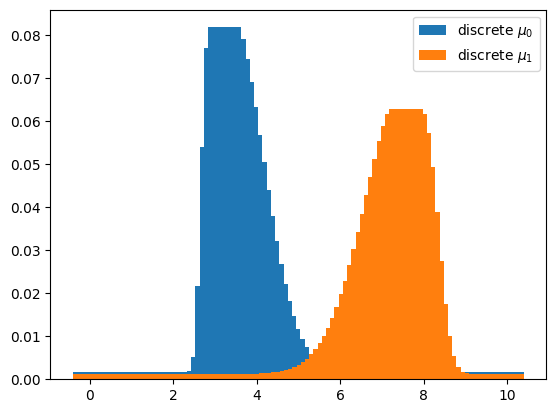

In [96]:
# plot discrete input distributions
plt.figure()
for j in range(J):
    plt.bar(x, A[:, j], label=f'discrete $\mu_{j}$')
plt.legend()
plt.show()

In [97]:
def bregman_algo(A: np.ndarray, x: np.ndarray,
                 epsilon : float,
                 niter : int = 500):
    """ uniform weights """

    [Y, X] = np.meshgrid(x, x)
    K = np.exp(- (X - Y)**2/ epsilon )

    weights = np.ones(J) / J

    # initialisation
    v = np.ones((M, J))
    u = np.copy(v)

    niter = 500
    for i in range(niter):

        # update u
        for k in range(J):
            u[:, k] = A[:, k] / np.dot(K, v[:, k])

        # compute barycenter
        b = np.zeros(M)
        for k in range(J):
            b += weights[k] * np.log( np.maximum(v[:, k] * np.dot(K, u[:, k]),
                                                1e-19*np.ones(M)))
        b = np.exp(b)

        # update v
        for k in range(J):
            v[:, k] = b / np.dot(K, u[:, k])

    return normalize(b)

def plot_result_hist(A, b):
  cols = ['darkorange', 'green']

  for j in range(J):
    plt.bar(x, A[:, j], width=.2, label=f'discrete $\mu_{j}$', color=cols[j])

  plt.bar(x, b, width=.2, label='barycenter', color='lightblue')
  plt.legend()

In [99]:
niter = 500
J = 2
epsilon = .01

In [ ]:
# Compare epsilon : The algorithm explodes for epsilon lower than .005
# Bregman algo
eps_list = [1, 0.5, .1, .008] # do not work for .005
# eps_list = np.linspace(.008, 1, 10)

fig = plt.figure(figsize=(15, 10))
for i, eps in enumerate(eps_list) :
    b = bregman_algo(A, x, eps, niter=niter)
    
    plt.subplot(2, 2, i+1)
    plot_result_hist(A, b)
    plt.title(f'$\epsilon={eps}$')

fig.savefig(figure_folder / 'sinkhorn_1D_2skew.png')

In [101]:
time_method_2 = []
y = np.linspace(0, 10, M)  
vmin = .01
for _ in range(10):
    time_start = time()
    A = np.zeros((M, J))
    for j in range(J):
        a = skewnorm.pdf(y, skews[j], loc=means[j], scale=stds[j])
        A[:, j] = normalize( a + a.max()*vmin )

    b = bregman_algo(A, y, epsilon, niter=niter)
    time_method_2 += [time() - time_start]
time_metrics_1D_skewnorm['Iterative_Bregman'] += [np.mean(time_method_2), np.std(time_method_2)]    

In [102]:
with open(result_path_1D_skewnorm, 'wb') as f:
    pickle.dump(time_metrics_1D_skewnorm, f)

### **Method 3** : ascent / snap

In [32]:
def sample_from_input_distribution(ind_j : int, n_samples : int = 10000):
    return skewnorm.rvs(skews[ind_j], loc=means[ind_j], scale=stds[ind_j], size=(n_samples, 1))

In [57]:
M = 100
n_samples = 16000
nIter = 1
J = 2
D = 1
ascent_eps = 1e-4 # 1e-6
ascent_beta = .99
ascent_alpha = 5e-2 # 1e-3,  try .1 ?

max_while_loop = 1500

x = np.linspace(0, 10, M)[:, np.newaxis] # (M, D)

In [58]:
time_algo_0 = time()
barycenter_pt, phis, ascent_criteria_list, ascent_time, snap_time = ascent_snap_algo(x, nIter, n_samples,
                                                                                ascent_eps=ascent_eps,
                                                                                ascent_beta=ascent_beta,
                                                                                ascent_alpha=ascent_alpha,
                                                                                J=J,
                                                                                M=M,
                                                                                sample_from_input_distribution=sample_from_input_distribution,
                                                                                max_while_loop=max_while_loop,
                                                                                config_exp="1D_2skewnorm")
time_algo_1 = time()

criteria for j 0 : 0.1906875


In [108]:
time_metrics_1D_skewnorm['Asncent_Snap_algorithm']['total'] = [time_algo_1 - time_algo_0] 
time_metrics_1D_skewnorm['Asncent_Snap_algorithm']['ascent_time'] = [ascent_time]
time_metrics_1D_skewnorm['Asncent_Snap_algorithm']['snap_time'] = [snap_time]
with open(result_path_1D_skewnorm, 'wb') as f:
    pickle.dump(time_metrics_1D_skewnorm, f)

In [111]:
x.shape

(100,)

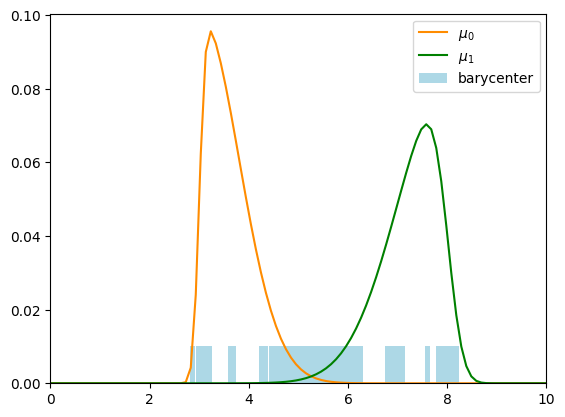

In [114]:
t = np.linspace(0, 10, 100)
mu_0 = normalize(skewnorm.pdf(t, skews[0], loc=means[0], scale=stds[0]))
mu_1 = normalize(skewnorm.pdf(t, skews[1], loc=means[1], scale=stds[1]))
colors = ['darkorange', 'green']
fig = plt.figure()
plt.bar(barycenter_pt[:, 0],  np.ones(M)/M, width=.1, label='barycenter', color = 'lightblue')
for i in range(2):
    plt.plot(t, eval(f'mu_{i}'), label=f"$\mu_{i}$", color=colors[i])
plt.legend()
plt.xlim(0, 10)
fig.savefig(figure_folder / 'ascent_snap_1D_2skewnorm.png')

### **Method 3** : Advanced Sinkhorn

In [ ]:
def mina_u(H, a, epsilon): return -epsilon*np.log( np.maximum(1e-19*np.ones(len(a)), np.sum(a * np.exp(-H/epsilon),0)) )
def minb_u(H, b, epsilon): return -epsilon*np.log( np.maximum(1e-19*np.ones(len(b)), np.sum(b * np.exp(-H/epsilon),1)) )

def mina(H, a, epsilon): return mina_u(H-np.min(H,0), a, epsilon) + np.min(H,0);
def minb(H, b, epsilon): return minb_u(H-np.min(H,1)[:,None], b, epsilon) + np.min(H,1)

In [ ]:
def Sinkhorn(a, b, C, epsilon,f,niter = 500):
    Err = np.zeros(niter)
    for it in range(niter):
        g = mina(C-f[:,None], a, epsilon)
        f = minb(C-g[None,:], b, epsilon)
        # generate the coupling
        P = a * np.exp((f[:,None]+g[None,:]-C)/epsilon) * b
        # check conservation of mass
        Err[it] = np.linalg.norm(np.sum(P,0)-b,1)
    return (P,Err)


# run with 0 initialization for the potential f
[Y, X] = np.meshgrid(x, x)
C = (X - Y)**2
epsilon = .01
(P,Err) =  Sinkhorn(A[:, 0], A[:, 1], C,epsilon, np.zeros(M),300)
plt.plot(np.log10(Err));

In [ ]:
plt.imshow(P)

In [ ]:
# do not work 
def log_domain_bregman_algo(A: np.ndarray, x: np.ndarray,
                 epsilon : float,
                 niter : int = 500):

    """ uniform weights """

    M, J = A.shape
    [Y, X] = np.meshgrid(x, x)
    C = (X - Y)**2
    K = np.exp( - C / epsilon)

    # initialization
    f = np.zeros((M, J))
    g = np.copy(f)

    # prev_b = np.ones(M)/M

    for it in range(niter):
        # update f
        for j in range(J):
            f[:, j] = minb(C - g[None, :, j], A[:, j], epsilon)

        # projection PT.1 = barycenter
        b = np.zeros(M)
        # for j in range(J):
        #     P = A[:, j] * np.exp((f[:,None, j]+g[None,:, j]-C)/epsilon) * prev_b
        #     b +=  np.log( np.maximum(P.sum(1),
        #                              1e-10 * np.ones(M)))
        u = np.exp( f/epsilon)
        v = np.exp( g/epsilon)
        for k in range(J):
            b += np.log( np.maximum(v[:, k] * np.dot(K, u[:, k]),
                                                1e-19*np.ones(M)))

        b = np.exp( b/J )
        b = normalize(b)
        # print(prev_b)
        

        # update g
        for j in range(J):
            g[:, j] = mina( C - f[:, None, j], b, epsilon)

    return b


In [ ]:
epsilon = .01
b = log_domain_bregman_algo(A, x, epsilon, niter=300)

# 2D 

In [37]:
result_path_2D_discrete = results_folder / 'time_metrics_2D_discrete.pkl'
if result_path_2D_discrete.exists():
    with open(result_path_2D_discrete, 'rb') as f:
        time_metrics_2D_discrete = pickle.load(f)
else :
    time_metrics_2D_discrete = {
        'Optimal_Monge_Map' : [],
        'Iterative Bregman' : [],
        'OT_free_support_Sinkhorn' : [],
        'Ascent_Snap_algorithm': {'total': [], 'ascent_time': [], 'snap_time': []}
    }

In [27]:
# generate data when generating between 1 and 4, ot.bregman do not work
J = 2
n = 40
X0 = np.concatenate([
    np.concatenate([-2*np.ones((n, 1)), np.random.rand(n, 1)*4 - 2], axis=1),
    np.concatenate([np.random.rand(n, 1)*4 - 2, 2*np.ones((n, 1))], axis=1),
    np.concatenate([np.ones((n, 1))*2, np.random.rand(n, 1)*4 - 2], axis=1),
    np.concatenate([np.random.rand(n, 1)*4 - 2, -2*np.ones((n, 1)) ], axis=1)
    ],
    axis=0)

sig = np.array([[.6, .5], [.5, .6]])
# sig = np.array([[1, .5], [.5, 1]])
print(np.linalg.det(sig))
X1 = np.random.multivariate_normal(np.array([0., 0.]), sig, size=n*4)

0.10999999999999997


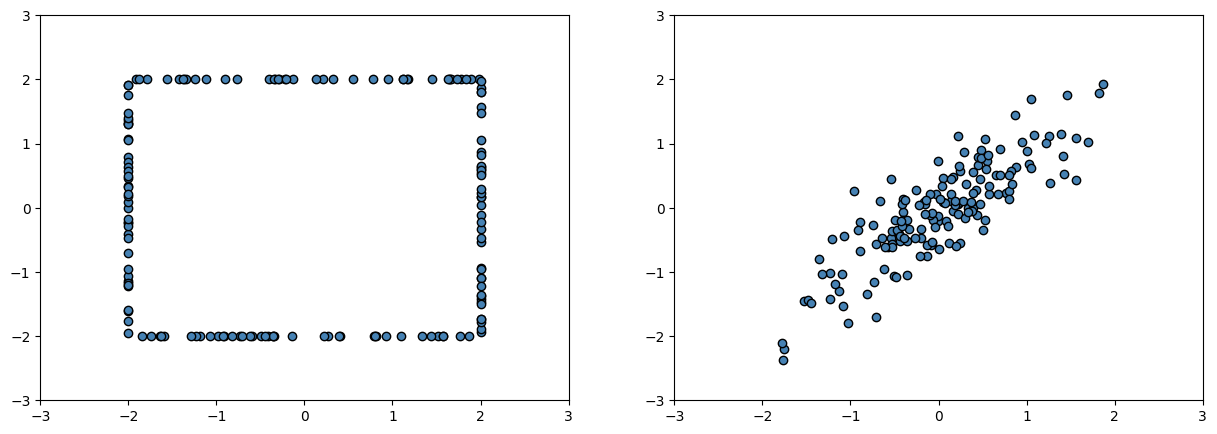

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(X0[:, 0], X0[:, 1], c='steelblue', edgecolor='k')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.subplot(1, 2, 2)
plt.scatter(X1[:, 0], X1[:, 1], c='steelblue', edgecolors='k')
plt.xlim(-3, 3)
plt.ylim(-3,3)
plt.show()

In [24]:
a0, a1 = ot.unif(len(X0)), ot.unif(len(X1))

### **Method** : OT free support Sinkhorn
https://pythonot.github.io/gen_modules/ot.bregman.html#ot.bregman.free_support_sinkhorn_barycenter

In [29]:
reg = 1e-2  # Entropic Regularization
numItermax = 20  # Maximum number of iterations for the Barycenter algorithm
numInnerItermax = 50  # Maximum number of sinkhorn iterations
n_samples = n*4
n_samples

160

In [212]:
X2 = 2 * np.concatenate([
    np.concatenate([- np.ones([50, 1]), np.linspace(-1, 1, 50)[:, None]], axis=1),
    np.concatenate([np.linspace(-1, 1, 50)[:, None], np.ones([50, 1])], axis=1),
    np.concatenate([np.ones([50, 1]), np.linspace(1, -1, 50)[:, None]], axis=1),
    np.concatenate([np.linspace(1, -1, 50)[:, None], - np.ones([50, 1])], axis=1),
], axis=0)
X4 = np.random.multivariate_normal(np.array([0, 0]), np.array([[1., 0.5], [0.5, 1.]]), size=200)

a2, a4 = ot.unif(len(X2)), ot.unif(len(X4))


In [30]:
weights = np.array([
    [1/ 2, 1 / 2]
]).astype(np.float32)

c:\Users\INES\Documents\3A_MVA\Computational Optimal Transport\projectOT_stochastic_wasserstein_barycenters\.venv\lib\site-packages\ot\bregman\_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 17
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


for reg 0.005, OT Barycenter done in 0.72 s
for reg 0.01, OT Barycenter done in 0.48 s
for reg 0.05, OT Barycenter done in 0.38 s
for reg 0.1, OT Barycenter done in 0.44 s
for reg 0.5, OT Barycenter done in 0.42 s
for reg 1, OT Barycenter done in 0.35 s


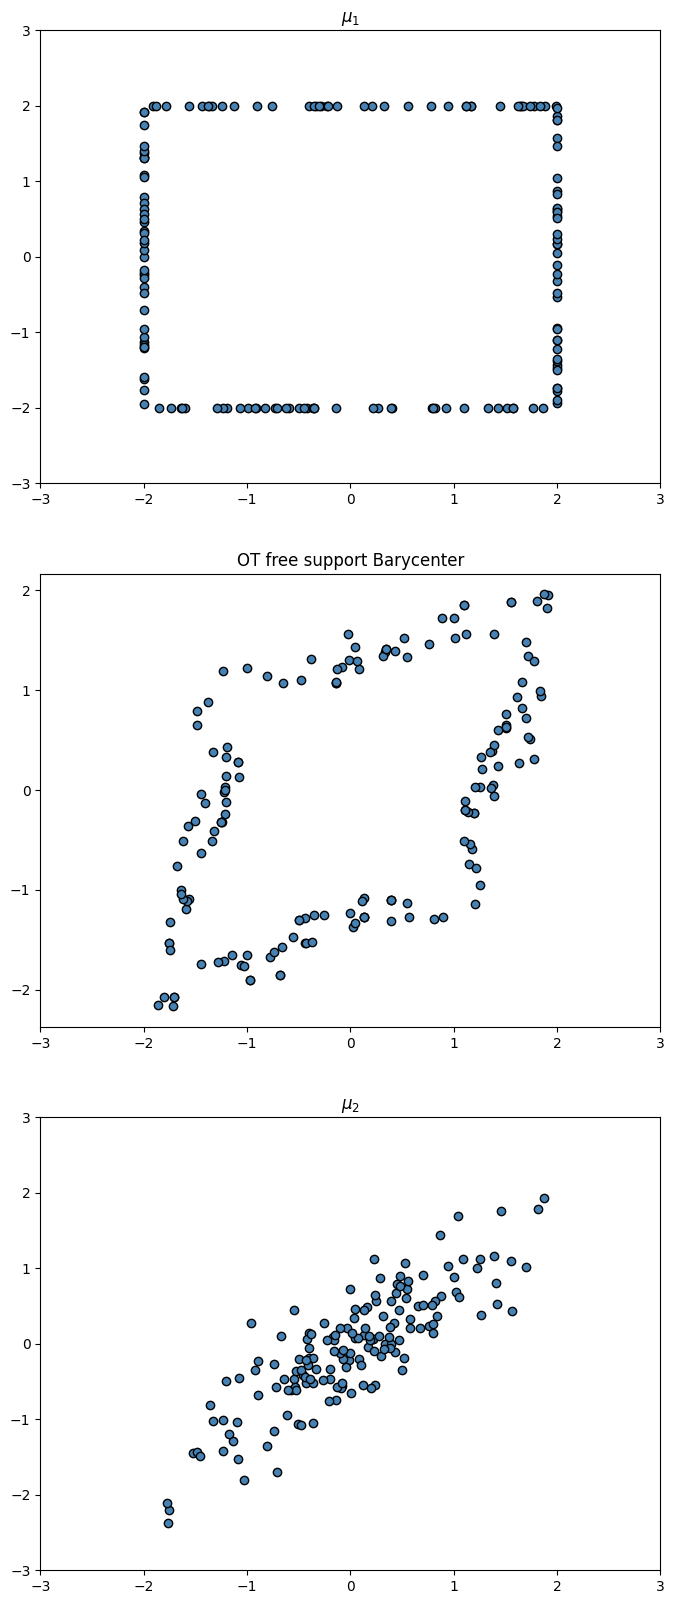

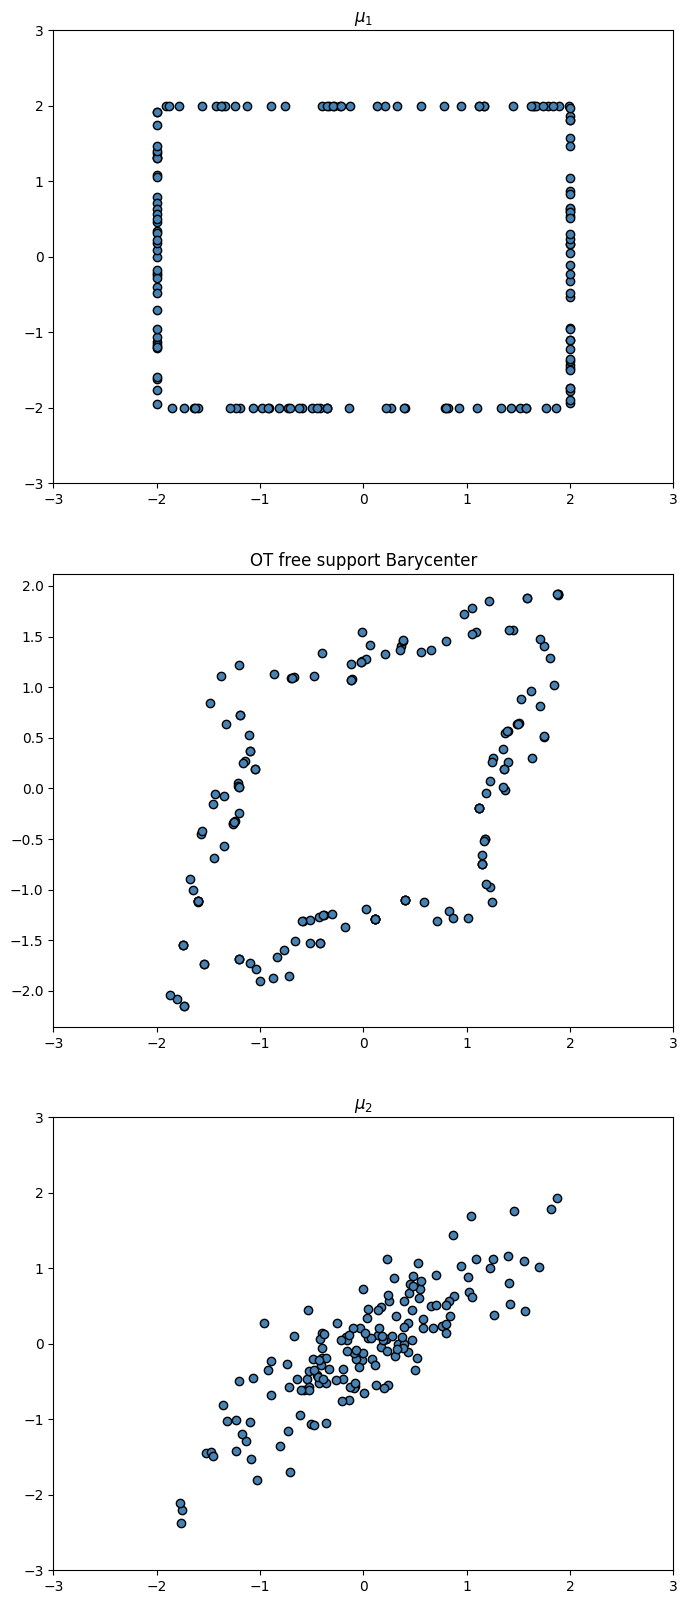

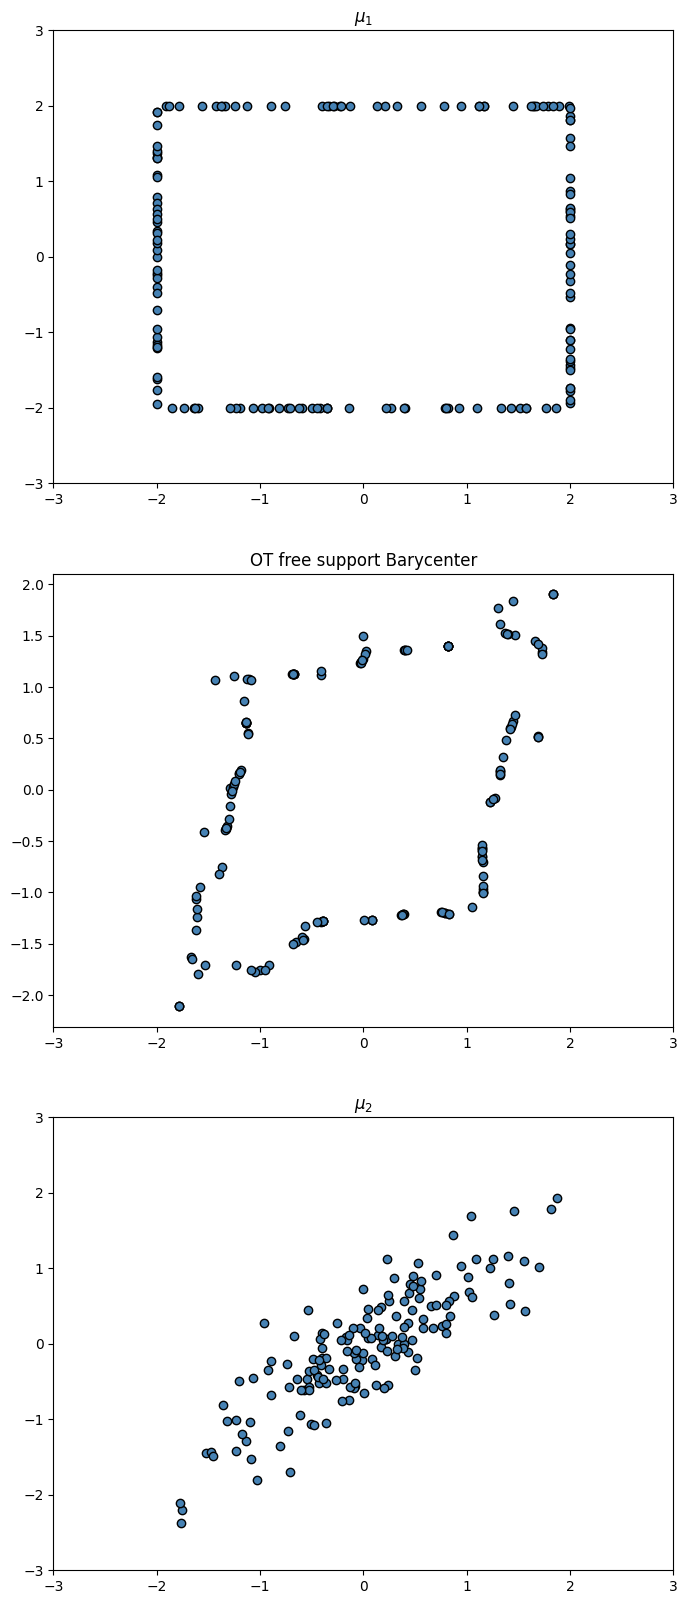

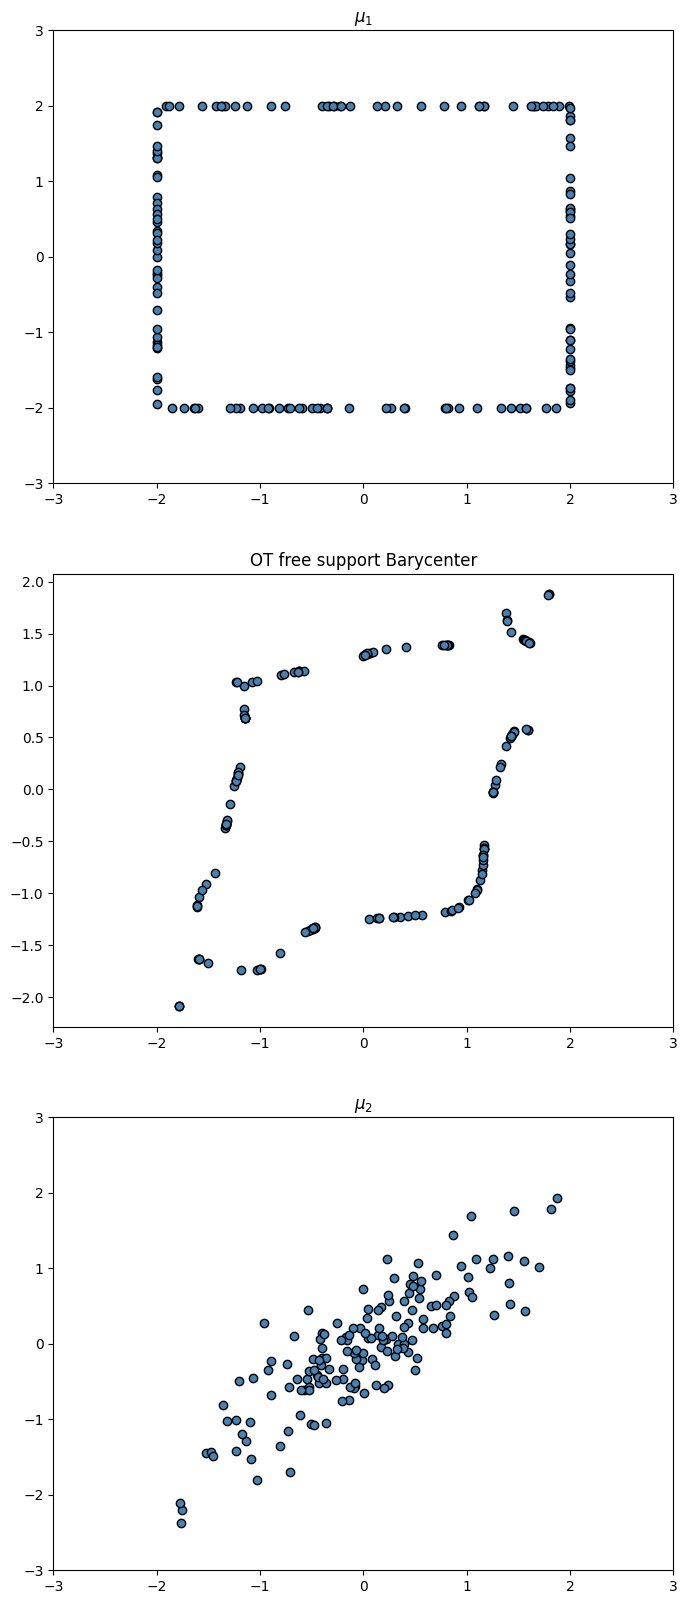

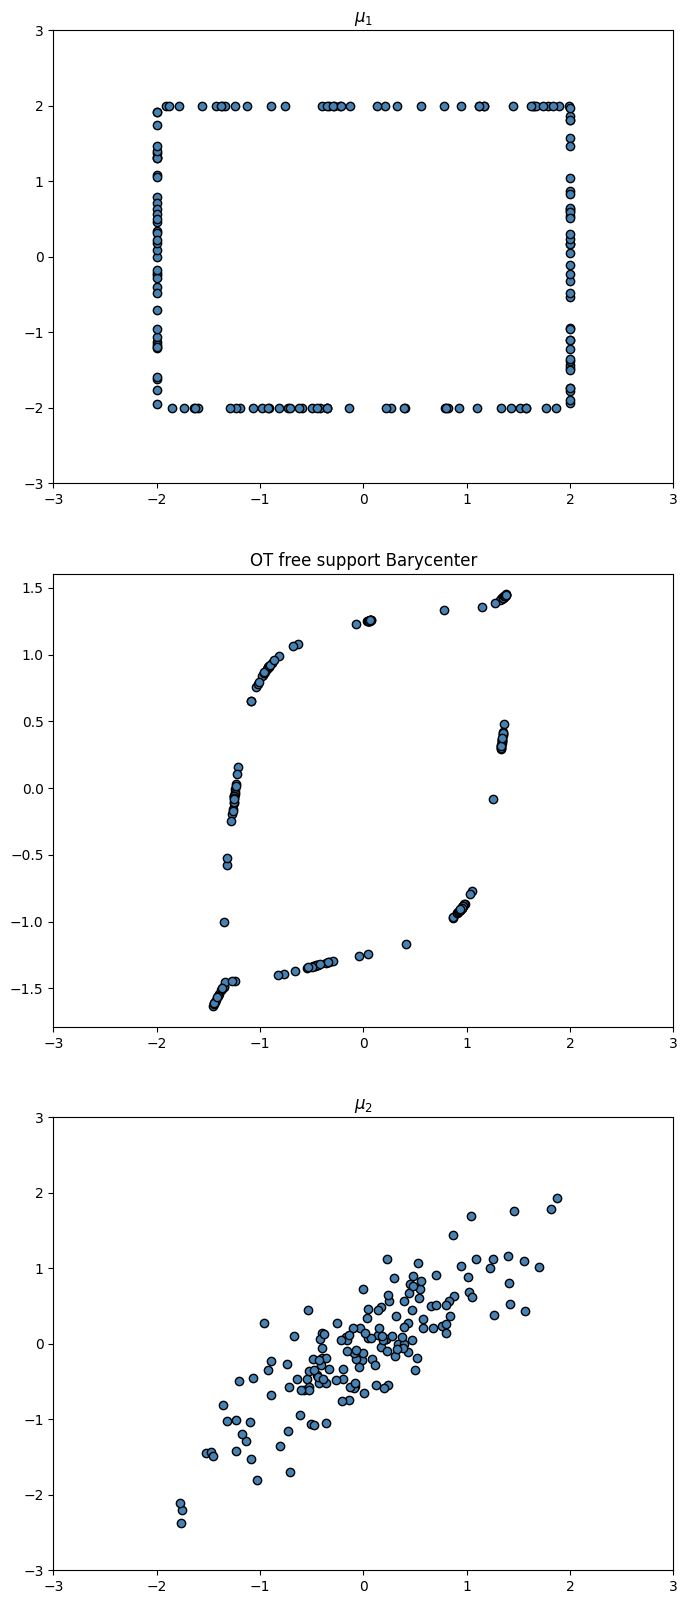

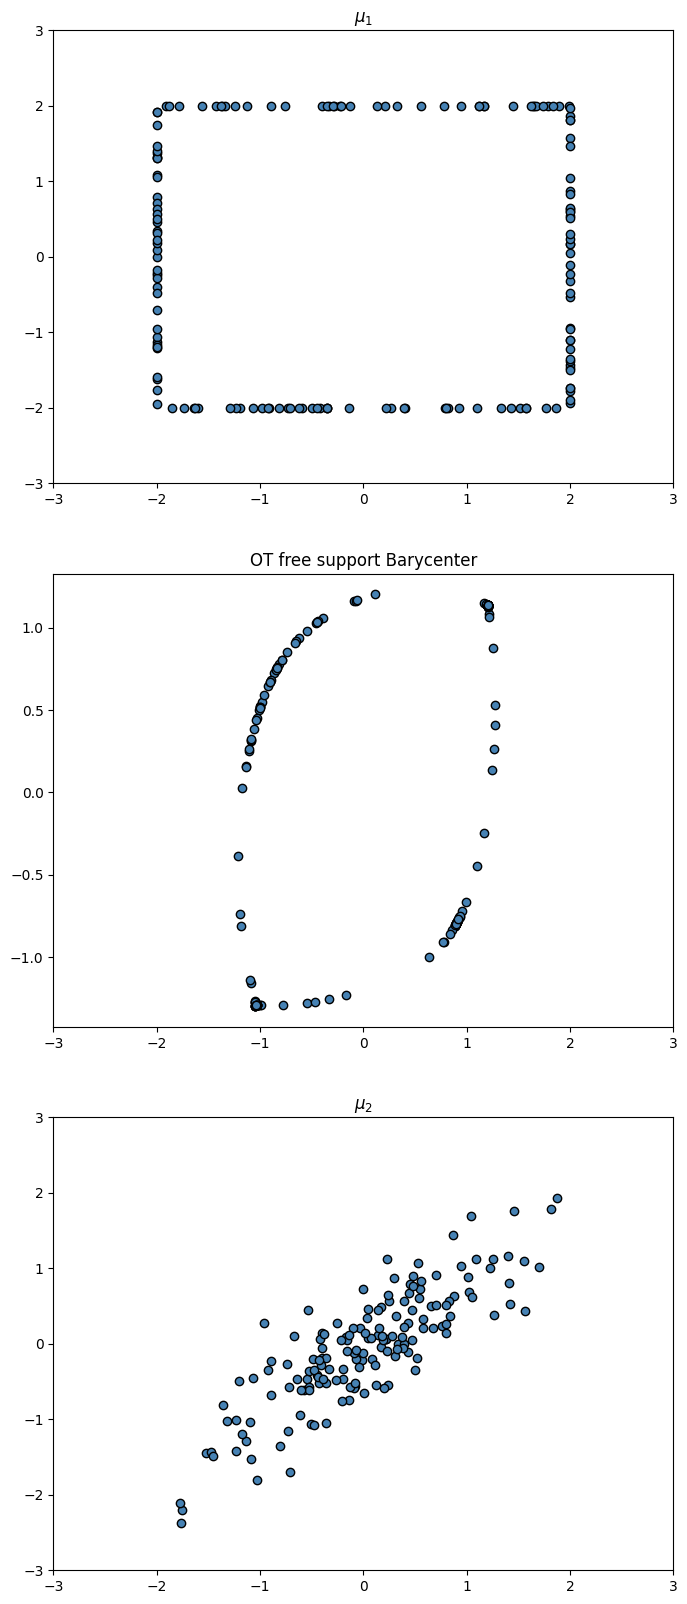

In [36]:
# Compare different reg parameters
regs = [.005, .01, .05, .1, .5, 1]
for reg in regs:
    time1 = time()

    b_init = np.random.randn(n*4, 2).astype(X0.dtype)
    Xb = ot.bregman.free_support_sinkhorn_barycenter(
        measures_locations=[X0, X1],
        measures_weights=[a0, a1],
        weights=weights[0],
        X_init=b_init,
        reg=reg, 
        numItermax=numItermax,
        numInnerItermax=numInnerItermax
    )
    print(f'for reg {reg}, OT Barycenter done in {time() - time1:.2f} s')

    fig = plt.figure(figsize=(8, 20))
    plt.subplot(3, 1, 1)
    plt.scatter(X0[:, 0], X0[:, 1], c='steelblue', edgecolor='k')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('$\mu_1$')
    plt.subplot(3, 1, 2)
    plt.scatter(Xb[:, 0], Xb[:, 1], c='steelblue', edgecolors='k')
    plt.title('OT free support Barycenter')
    plt.xlim(-3, 3)
    plt.xlim(-3, 3)
    plt.subplot(3, 1, 3)
    plt.scatter(X1[:, 0], X1[:, 1], c='steelblue', edgecolors='k')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('$\mu_2$')

    fig.savefig(figure_folder / f'ot_barycenter_reg{reg}.png')

In [39]:
# Get time metrics
reg = .005
time_method_ot = []
for _ in range(10):
    time1 = time()

    b_init = np.random.randn(n*4, 2).astype(X0.dtype)
    Xb = ot.bregman.free_support_sinkhorn_barycenter(
        measures_locations=[X0, X1],
        measures_weights=[a0, a1],
        weights=weights[0],
        X_init=b_init,
        reg=reg, 
        numItermax=numItermax,
        numInnerItermax=numInnerItermax
    )
    time_method_ot += [time() - time1]
    
time_metrics_2D_discrete['OT_free_support_Sinkhorn'] += [np.mean(time_method_ot), np.std(time_method_ot)]

c:\Users\INES\Documents\3A_MVA\Computational Optimal Transport\projectOT_stochastic_wasserstein_barycenters\.venv\lib\site-packages\ot\bregman\_sinkhorn.py:499: RuntimeWarning: overflow encountered in divide
  u = 1. / nx.dot(Kp, v)
c:\Users\INES\Documents\3A_MVA\Computational Optimal Transport\projectOT_stochastic_wasserstein_barycenters\.venv\lib\site-packages\ot\bregman\_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 21
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
c:\Users\INES\Documents\3A_MVA\Computational Optimal Transport\projectOT_stochastic_wasserstein_barycenters\.venv\lib\site-packages\ot\bregman\_sinkhorn.py:499: RuntimeWarning: divide by zero encountered in divide
  u = 1. / nx.dot(Kp, v)
c:\Users\INES\Documents\3A_MVA\Computational Optimal Transport\projectOT_stochastic_wasserstein_barycenters\.venv\lib\site-packages\ot\bregman\_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numer

In [40]:
with open(result_path_2D_discrete, 'wb') as f:
    pickle.dump(time_metrics_2D_discrete, f)

### **Method** : Ascent / snap algo

In [72]:
def sample_from_distribution_exp2(ind_j : int, n_samples : int = 100):
    """ Here, the point are uniformly distributed """
    grid = eval(f'X{ind_j}')
    ind_sample = np.random.choice(len(grid), size=n_samples, replace=True)
    return grid[ind_sample]


M = 100
n_samples = 16000
nIter = 1
J = 2
D = 2
ascent_eps = 1e-4 # 1e-6
ascent_beta = .99
ascent_alpha = 5e-2 # 1e-3,  try .1 ?

max_while_loop = 1500

# t = np.linspace(-3, 3, np.sqrt(M).astype(int))
# xx, yy = np.meshgrid(t, t) 
# x = np.stack( xx.ravel(), yy.ravel(), axis=0) # (M, D)

x_init = np.random.randn(M, D)

In [73]:
time_algo_0 = time()
barycenter_pt, phis, ascent_criteria_list, ascent_time, snap_time = ascent_snap_algo(x_init, nIter, n_samples, 
                                                                                     ascent_eps,
                                                                                     ascent_beta,
                                                                                     ascent_alpha,
                                                                                     J, M, 
                                                                                     sample_from_distribution_exp2,
                                                                                     D=D,
                                                                                     plot=True,
                                                                                     config_exp="2D_discrete")
time_algo_1 = time()

C:\Users\INES\AppData\Local\Temp\ipykernel_13416\2439744480.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "ascent_snap_algo" failed type inference due to: Untyped global name 'time': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_13416\2439744480.py", line 20:
<source missing, REPL/exec in use?>

  @jit
C:\Users\INES\AppData\Local\Temp\ipykernel_13416\2439744480.py:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "ascent_snap_algo" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "..\..\..\..\..\AppData\Local\Temp\ipykernel_13416\2439744480.py", line 19:
<source missing, REPL/exec in use?>

  @jit
c:\Users\INES\Documents\3A_MVA\Computational Optimal Transport\projectOT_stochastic_wasserstein_barycenters\.venv\lib\site-packages\numba\core\ob

## 1D Case : Dirac 

In [ ]:
a1 = np.zeros(M)
a2 = np.zeros(M)

a1[8] = .5
a1[10] = .5
a2[2] = .5
a2[4] = .5

print(a1.sum())

In [ ]:
plt.plot(x, a1, label='$\mu_1$')
plt.plot(x, a2, label='$\mu_2$')
plt.legend()
plt.show()